!pip install apyori

In [169]:
%%writefile apyori.py

#or
#!pip install apyori
#!/usr/bin/env python

"""
A simple implementation of Apriori Algorithm in Python.
"""

import sys
import csv
import argparse
import json
import os
from collections import namedtuple
from itertools import combinations
from itertools import chain


# Meta informations.
__version__ = '1.1.2'
__author__ = 'Yu Mochizuki'
__author_email__ = 'ymoch.dev@gmail.com'


################################################################################
# Data structures.
################################################################################
class TransactionManager(object):
    """
    Transaction managers.
    """

    def __init__(self, transactions):
        """
        Initialize.

        Arguments:
            transactions -- A transaction iterable object
                            (eg. [['A', 'B'], ['B', 'C']]).
        """
        self.__num_transaction = 0
        self.__items = []
        self.__transaction_index_map = {}

        for transaction in transactions:
            self.add_transaction(transaction)

    def add_transaction(self, transaction):
        """
        Add a transaction.

        Arguments:
            transaction -- A transaction as an iterable object (eg. ['A', 'B']).
        """
        for item in transaction:
            if item not in self.__transaction_index_map:
                self.__items.append(item)
                self.__transaction_index_map[item] = set()
            self.__transaction_index_map[item].add(self.__num_transaction)
        self.__num_transaction += 1

    def calc_support(self, items):
        """
        Returns a support for items.

        Arguments:
            items -- Items as an iterable object (eg. ['A', 'B']).
        """
        # Empty items is supported by all transactions.
        if not items:
            return 1.0

        # Empty transactions supports no items.
        if not self.num_transaction:
            return 0.0

        # Create the transaction index intersection.
        sum_indexes = None
        for item in items:
            indexes = self.__transaction_index_map.get(item)
            if indexes is None:
                # No support for any set that contains a not existing item.
                return 0.0

            if sum_indexes is None:
                # Assign the indexes on the first time.
                sum_indexes = indexes
            else:
                # Calculate the intersection on not the first time.
                sum_indexes = sum_indexes.intersection(indexes)

        # Calculate and return the support.
        return float(len(sum_indexes)) / self.__num_transaction

    def initial_candidates(self):
        """
        Returns the initial candidates.
        """
        return [frozenset([item]) for item in self.items]

    @property
    def num_transaction(self):
        """
        Returns the number of transactions.
        """
        return self.__num_transaction

    @property
    def items(self):
        """
        Returns the item list that the transaction is consisted of.
        """
        return sorted(self.__items)

    @staticmethod
    def create(transactions):
        """
        Create the TransactionManager with a transaction instance.
        If the given instance is a TransactionManager, this returns itself.
        """
        if isinstance(transactions, TransactionManager):
            return transactions
        return TransactionManager(transactions)


# Ignore name errors because these names are namedtuples.
SupportRecord = namedtuple( # pylint: disable=C0103
    'SupportRecord', ('items', 'support'))
RelationRecord = namedtuple( # pylint: disable=C0103
    'RelationRecord', SupportRecord._fields + ('ordered_statistics',))
OrderedStatistic = namedtuple( # pylint: disable=C0103
    'OrderedStatistic', ('items_base', 'items_add', 'confidence', 'lift',))


################################################################################
# Inner functions.
################################################################################
def create_next_candidates(prev_candidates, length):
    """
    Returns the apriori candidates as a list.

    Arguments:
        prev_candidates -- Previous candidates as a list.
        length -- The lengths of the next candidates.
    """
    # Solve the items.
    items = sorted(frozenset(chain.from_iterable(prev_candidates)))

    # Create the temporary candidates. These will be filtered below.
    tmp_next_candidates = (frozenset(x) for x in combinations(items, length))

    # Return all the candidates if the length of the next candidates is 2
    # because their subsets are the same as items.
    if length < 3:
        return list(tmp_next_candidates)

    # Filter candidates that all of their subsets are
    # in the previous candidates.
    next_candidates = [
        candidate for candidate in tmp_next_candidates
        if all(
            frozenset(x) in prev_candidates
            for x in combinations(candidate, length - 1))
    ]
    return next_candidates


def gen_support_records(transaction_manager, min_support, **kwargs):
    """
    Returns a generator of support records with given transactions.

    Arguments:
        transaction_manager -- Transactions as a TransactionManager instance.
        min_support -- A minimum support (float).

    Keyword arguments:
        max_length -- The maximum length of relations (integer).
    """
    # Parse arguments.
    max_length = kwargs.get('max_length')

    # For testing.
    _create_next_candidates = kwargs.get(
        '_create_next_candidates', create_next_candidates)

    # Process.
    candidates = transaction_manager.initial_candidates()
    length = 1
    while candidates:
        relations = set()
        for relation_candidate in candidates:
            support = transaction_manager.calc_support(relation_candidate)
            if support < min_support:
                continue
            candidate_set = frozenset(relation_candidate)
            relations.add(candidate_set)
            yield SupportRecord(candidate_set, support)
        length += 1
        if max_length and length > max_length:
            break
        candidates = _create_next_candidates(relations, length)


def gen_ordered_statistics(transaction_manager, record):
    """
    Returns a generator of ordered statistics as OrderedStatistic instances.

    Arguments:
        transaction_manager -- Transactions as a TransactionManager instance.
        record -- A support record as a SupportRecord instance.
    """
    items = record.items
    sorted_items = sorted(items)
    for base_length in range(len(items)):
        for combination_set in combinations(sorted_items, base_length):
            items_base = frozenset(combination_set)
            items_add = frozenset(items.difference(items_base))
            confidence = (
                record.support / transaction_manager.calc_support(items_base))
            lift = confidence / transaction_manager.calc_support(items_add)
            yield OrderedStatistic(
                frozenset(items_base), frozenset(items_add), confidence, lift)


def filter_ordered_statistics(ordered_statistics, **kwargs):
    """
    Filter OrderedStatistic objects.

    Arguments:
        ordered_statistics -- A OrderedStatistic iterable object.

    Keyword arguments:
        min_confidence -- The minimum confidence of relations (float).
        min_lift -- The minimum lift of relations (float).
    """
    min_confidence = kwargs.get('min_confidence', 0.0)
    min_lift = kwargs.get('min_lift', 0.0)

    for ordered_statistic in ordered_statistics:
        if ordered_statistic.confidence < min_confidence:
            continue
        if ordered_statistic.lift < min_lift:
            continue
        yield ordered_statistic


################################################################################
# API function.
################################################################################
def apriori(transactions, **kwargs):
    """
    Executes Apriori algorithm and returns a RelationRecord generator.

    Arguments:
        transactions -- A transaction iterable object
                        (eg. [['A', 'B'], ['B', 'C']]).

    Keyword arguments:
        min_support -- The minimum support of relations (float).
        min_confidence -- The minimum confidence of relations (float).
        min_lift -- The minimum lift of relations (float).
        max_length -- The maximum length of the relation (integer).
    """
    # Parse the arguments.
    min_support = kwargs.get('min_support', 0.1)
    min_confidence = kwargs.get('min_confidence', 0.0)
    min_lift = kwargs.get('min_lift', 0.0)
    max_length = kwargs.get('max_length', None)

    # Check arguments.
    if min_support <= 0:
        raise ValueError('minimum support must be > 0')

    # For testing.
    _gen_support_records = kwargs.get(
        '_gen_support_records', gen_support_records)
    _gen_ordered_statistics = kwargs.get(
        '_gen_ordered_statistics', gen_ordered_statistics)
    _filter_ordered_statistics = kwargs.get(
        '_filter_ordered_statistics', filter_ordered_statistics)

    # Calculate supports.
    transaction_manager = TransactionManager.create(transactions)
    support_records = _gen_support_records(
        transaction_manager, min_support, max_length=max_length)

    # Calculate ordered stats.
    for support_record in support_records:
        ordered_statistics = list(
            _filter_ordered_statistics(
                _gen_ordered_statistics(transaction_manager, support_record),
                min_confidence=min_confidence,
                min_lift=min_lift,
            )
        )
        if not ordered_statistics:
            continue
        yield RelationRecord(
            support_record.items, support_record.support, ordered_statistics)


################################################################################
# Application functions.
################################################################################
def parse_args(argv):
    """
    Parse commandline arguments.

    Arguments:
        argv -- An argument list without the program name.
    """
    output_funcs = {
        'json': dump_as_json,
        'tsv': dump_as_two_item_tsv,
    }
    default_output_func_key = 'json'

    parser = argparse.ArgumentParser()
    parser.add_argument(
        '-v', '--version', action='version',
        version='%(prog)s {0}'.format(__version__))
    parser.add_argument(
        'input', metavar='inpath', nargs='*',
        help='Input transaction file (default: stdin).',
        type=argparse.FileType('r'), default=[sys.stdin])
    parser.add_argument(
        '-o', '--output', metavar='outpath',
        help='Output file (default: stdout).',
        type=argparse.FileType('w'), default=sys.stdout)
    parser.add_argument(
        '-l', '--max-length', metavar='int',
        help='Max length of relations (default: infinite).',
        type=int, default=None)
    parser.add_argument(
        '-s', '--min-support', metavar='float',
        help='Minimum support ratio (must be > 0, default: 0.1).',
        type=float, default=0.1)
    parser.add_argument(
        '-c', '--min-confidence', metavar='float',
        help='Minimum confidence (default: 0.5).',
        type=float, default=0.5)
    parser.add_argument(
        '-t', '--min-lift', metavar='float',
        help='Minimum lift (default: 0.0).',
        type=float, default=0.0)
    parser.add_argument(
        '-d', '--delimiter', metavar='str',
        help='Delimiter for items of transactions (default: tab).',
        type=str, default='\t')
    parser.add_argument(
        '-f', '--out-format', metavar='str',
        help='Output format ({0}; default: {1}).'.format(
            ', '.join(output_funcs.keys()), default_output_func_key),
        type=str, choices=output_funcs.keys(), default=default_output_func_key)
    args = parser.parse_args(argv)

    args.output_func = output_funcs[args.out_format]
    return args


def load_transactions(input_file, **kwargs):
    """
    Load transactions and returns a generator for transactions.

    Arguments:
        input_file -- An input file.

    Keyword arguments:
        delimiter -- The delimiter of the transaction.
    """
    delimiter = kwargs.get('delimiter', '\t')
    for transaction in csv.reader(input_file, delimiter=delimiter):
        yield transaction if transaction else ['']


def dump_as_json(record, output_file):
    """
    Dump an relation record as a json value.

    Arguments:
        record -- A RelationRecord instance to dump.
        output_file -- A file to output.
    """
    def default_func(value):
        """
        Default conversion for JSON value.
        """
        if isinstance(value, frozenset):
            return sorted(value)
        raise TypeError(repr(value) + " is not JSON serializable")

    converted_record = record._replace(
        ordered_statistics=[x._asdict() for x in record.ordered_statistics])
    json.dump(
        converted_record._asdict(), output_file,
        default=default_func, ensure_ascii=False)
    output_file.write(os.linesep)


def dump_as_two_item_tsv(record, output_file):
    """
    Dump a relation record as TSV only for 2 item relations.

    Arguments:
        record -- A RelationRecord instance to dump.
        output_file -- A file to output.
    """
    for ordered_stats in record.ordered_statistics:
        if len(ordered_stats.items_base) != 1:
            continue
        if len(ordered_stats.items_add) != 1:
            continue
        output_file.write('{0}\t{1}\t{2:.8f}\t{3:.8f}\t{4:.8f}{5}'.format(
            list(ordered_stats.items_base)[0], list(ordered_stats.items_add)[0],
            record.support, ordered_stats.confidence, ordered_stats.lift,
            os.linesep))


def main(**kwargs):
    """
    Executes Apriori algorithm and print its result.
    """
    # For tests.
    _parse_args = kwargs.get('_parse_args', parse_args)
    _load_transactions = kwargs.get('_load_transactions', load_transactions)
    _apriori = kwargs.get('_apriori', apriori)

    args = _parse_args(sys.argv[1:])
    transactions = _load_transactions(
        chain(*args.input), delimiter=args.delimiter)
    result = _apriori(
        transactions,
        max_length=args.max_length,
        min_support=args.min_support,
        min_confidence=args.min_confidence)
    for record in result:
        args.output_func(record, args.output)


if __name__ == '__main__':
    main()

Overwriting apyori.py


In [170]:
%%writefile ARutils.py

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def extract(rules, filter= "All", min_element=1):
    # rules: a list containing the association rules.
    # filter: default value is 'all'; however, you can filter out any RHS item
    # min_element: default value is 1, it defines the minimum number of elements in each rule
    """
    extract function accepts a list of association rules and the above parameters, and shows the extracted rules
    and returns the related metrics and the extracted rules.
    """
    LHS_list = []
    RHS_list = []
    support = []
    confidence = []
    lift = []
    for relation_record in rules:
        num_of_rules = len(relation_record[2])
        for itemset in range(num_of_rules):
            LHS_list.append(list(relation_record[2][itemset][0]))
            RHS_list.append(list(relation_record[2][itemset][1]))
            support.append(relation_record[1])
            confidence.append(relation_record[2][itemset][2])
            lift.append(relation_record[2][itemset][3])
    associationRules = []
    for rule in range(len(LHS_list)):
        if len(LHS_list[rule]) + len(RHS_list[rule]) < min_element:
            continue
        if (filter == 'All') | (filter in RHS_list[rule]):
            associationRules.append([LHS_list[rule], RHS_list[rule], support[rule], confidence[rule], lift[rule]])
    return associationRules


def data_prepare(dataset, filter='All'):
    # dataset is a dataframe where each columns
    # is an item, and each value is either yes or no to show whether an item exists in a transaction.
    # filter: default value is 'All'; however, it is possible to filter out transactions containing a specific item.
    """
    data_prepare accepts a dataframe and a given filter and returns a list of lists containig
    item sets in all transactions.
    """
    transactions = []
    columns = dataset.columns.tolist()
    for row in dataset.iterrows():
        tr = []
        for col in columns:
            if row[1][col] == 'Yes':
                tr.append(col)
        if (filter== 'All') | (filter in tr):
            transactions.append(tr)
    return transactions

def plot(supp, conf, lif):
    # supp: a list of calculated supports of the extracted rules.
    # conf: a list of calculated confidence of the extracted rules.
    # lif: a list of calculated lifts of the extracted rules.

    x = np.array(supp)
    y = np.array(conf)
    plt.xlabel('Support')
    plt.ylabel('Confidence')
    colors = np.array(lif)
    plt.scatter(x, y, c=colors, cmap='CMRmap')
    plt.colorbar()
    plt.show()

def inspect(rules):
    print("The number of associated rules:",len(rules))
    if len(rules) == 0:
        return
    for rule in rules:
        print("LHS: "+ str(rule[0])+" -->"+" RHS:"+ str(rule[1])+ ", support: "+ "{:.2f}".format(rule[2]) +", confidence: " + "{:.2f}".format(rule[3]) +", lift: "+ "{:.2f}".format(rule[4]))
        print(20*"----")

Overwriting ARutils.py


In [171]:
import matplotlib. pyplot as plt
import pandas as pd
from apyori import apriori

import ARutils
%matplotlib inline

In [172]:
store_data = pd.read_csv('/content/marketbasket.csv')

In [173]:
store_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   apples     1000 non-null   object
 1   banana     1000 non-null   object
 2   coke       1000 non-null   object
 3   turkey     1000 non-null   object
 4   bourbon    1000 non-null   object
 5   ice_cream  1000 non-null   object
 6   baguette   1000 non-null   object
 7   soda       1000 non-null   object
 8   choclate   1000 non-null   object
 9   cracker    1000 non-null   object
 10  cosmetics  1000 non-null   object
 11  avocado    1000 non-null   object
 12  artichoke  1000 non-null   object
 13  sardines   1000 non-null   object
dtypes: object(14)
memory usage: 109.5+ KB


In [174]:
store_data.shape

(1000, 14)

In [175]:
store_data.columns

Index(['apples', 'banana', 'coke', 'turkey', 'bourbon', 'ice_cream',
       'baguette', 'soda', 'choclate', 'cracker', 'cosmetics', 'avocado',
       'artichoke', 'sardines'],
      dtype='object')

In [176]:
store_data.head(10)

,apples,banana,coke,turkey,bourbon,ice_cream,baguette,soda,choclate,cracker,cosmetics,avocado,artichoke,sardines
0,No,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,No,No,No,Yes
1,No,No,Yes,No,Yes,No,Yes,Yes,No,No,Yes,Yes,No,No
2,No,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No
3,No,No,Yes,Yes,Yes,No,Yes,No,No,No,Yes,No,No,Yes
4,No,Yes,No,No,Yes,No,Yes,Yes,Yes,Yes,No,Yes,Yes,No
5,No,No,No,No,Yes,No,No,No,No,No,No,No,No,Yes
6,No,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No
7,No,No,Yes,Yes,No,No,Yes,No,Yes,Yes,No,Yes,No,No
8,No,No,No,No,Yes,No,No,No,No,No,Yes,No,Yes,No
9,Yes,Yes,Yes,Yes,No,No,No,No,Yes,Yes,No,No,No,No


In [177]:
store_data.describe()

,apples,banana,coke,turkey,bourbon,ice_cream,baguette,soda,choclate,cracker,cosmetics,avocado,artichoke,sardines
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No
freq,946,637,720,851,558,958,721,766,643,619,536,510,678,543


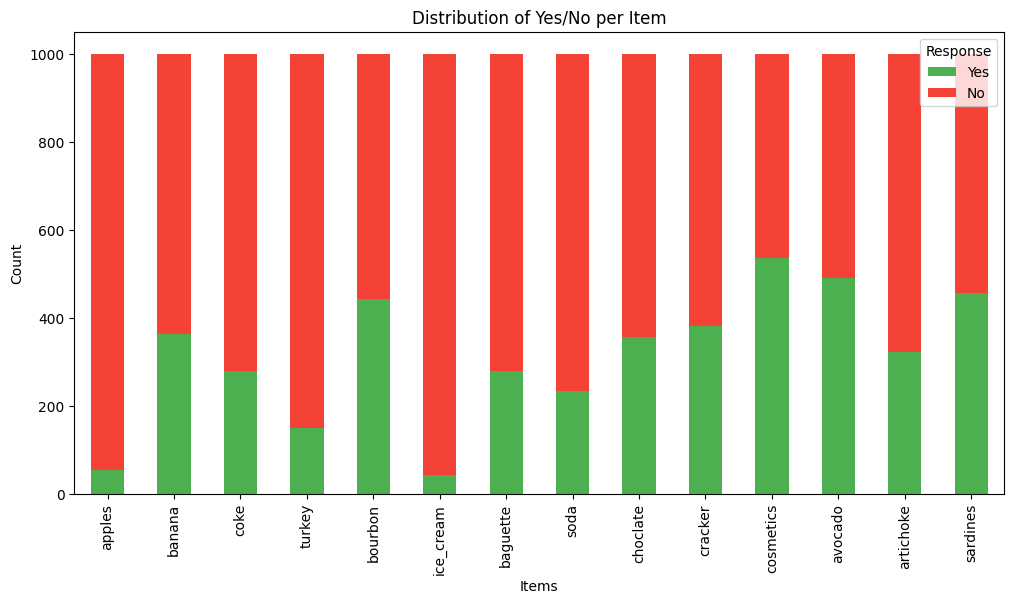

In [178]:
# Count Yes and No per column
yes_counts = (store_data == "Yes").sum()
no_counts  = (store_data == "No").sum()

# Combine into a DataFrame
dist = pd.DataFrame({"Yes": yes_counts, "No": no_counts})

# Plot as stacked bar chart
ax = dist.plot.bar(stacked=True, figsize=(12,6), color=["#4CAF50", "#F44336"])
plt.title("Distribution of Yes/No per Item")
plt.xlabel("Items")
plt.ylabel("Count")
plt.legend(title="Response")
plt.show()

In [179]:
# Creating Sample Transactions
transactions = [
  ['Milk', 'Bread', 'Saffron' ],
  ['Milk', 'Saffron'],
  ['Bread' , 'Saffron' , 'Wafer ' ],
  ['Bread' , 'Wafer'],
]

In [180]:
Rules = list(apriori(transactions, min_support=0.2, min_confidence=0.5))
associationRules = ARutils.extract(Rules)
rules_df = pd.DataFrame(associationRules, columns=['LHS' , 'RHS', 'Support', 'Confidence', 'Lift'])
rules_df

,LHS,RHS,Support,Confidence,Lift
0,[],[Bread],0.75,0.750000,1.000000
1,[],[Milk],0.50,0.500000,1.000000
2,[],[Saffron],0.75,0.750000,1.000000
3,[Milk],[Bread],0.25,0.500000,0.666667
4,[],"[Saffron, Bread]",0.50,0.500000,1.000000
5,[Bread],[Saffron],0.50,0.666667,0.888889
6,[Saffron],[Bread],0.50,0.666667,0.888889
7,[Wafer],[Bread],0.25,1.000000,1.333333
8,[Wafer ],[Bread],0.25,1.000000,1.333333
9,[],"[Milk, Saffron]",0.50,0.500000,1.000000


In [181]:
ARutils.inspect(associationRules)

The number of associated rules: 21
LHS: [] --> RHS:['Bread'], support: 0.75, confidence: 0.75, lift: 1.00
--------------------------------------------------------------------------------
LHS: [] --> RHS:['Milk'], support: 0.50, confidence: 0.50, lift: 1.00
--------------------------------------------------------------------------------
LHS: [] --> RHS:['Saffron'], support: 0.75, confidence: 0.75, lift: 1.00
--------------------------------------------------------------------------------
LHS: ['Milk'] --> RHS:['Bread'], support: 0.25, confidence: 0.50, lift: 0.67
--------------------------------------------------------------------------------
LHS: [] --> RHS:['Saffron', 'Bread'], support: 0.50, confidence: 0.50, lift: 1.00
--------------------------------------------------------------------------------
LHS: ['Bread'] --> RHS:['Saffron'], support: 0.50, confidence: 0.67, lift: 0.89
--------------------------------------------------------------------------------
LHS: ['Saffron'] --> RHS:[

In [182]:
ARutils.data_prepare(store_data)

[['banana',
  'coke',
  'turkey',
  'bourbon',
  'baguette',
  'soda',
  'choclate',
  'sardines'],
 ['coke', 'bourbon', 'baguette', 'soda', 'cosmetics', 'avocado'],
 ['banana',
  'bourbon',
  'ice_cream',
  'baguette',
  'soda',
  'choclate',
  'cracker',
  'cosmetics',
  'avocado',
  'artichoke'],
 ['coke', 'turkey', 'bourbon', 'baguette', 'cosmetics', 'sardines'],
 ['banana',
  'bourbon',
  'baguette',
  'soda',
  'choclate',
  'cracker',
  'avocado',
  'artichoke'],
 ['bourbon', 'sardines'],
 ['banana',
  'coke',
  'turkey',
  'bourbon',
  'baguette',
  'soda',
  'choclate',
  'cracker',
  'cosmetics',
  'avocado'],
 ['coke', 'turkey', 'baguette', 'choclate', 'cracker', 'avocado'],
 ['bourbon', 'cosmetics', 'artichoke'],
 ['apples', 'banana', 'coke', 'turkey', 'choclate', 'cracker'],
 ['coke', 'baguette', 'avocado', 'artichoke', 'sardines'],
 ['coke', 'turkey', 'bourbon', 'baguette', 'choclate', 'cracker', 'cosmetics'],
 ['banana', 'bourbon', 'soda', 'choclate', 'cracker', 'avocado

In [183]:
Rules = list(apriori(transactions, min_support=0.2, min_confidence=0.2))
associationRules = ARutils.extract(Rules)
rules_df = pd.DataFrame(associationRules, columns=['LHS' , 'RHS', 'Support', 'Confidence', 'Lift'])
rules_df

,LHS,RHS,Support,Confidence,Lift
0,[],[Bread],0.75,0.750000,1.000000
1,[],[Milk],0.50,0.500000,1.000000
2,[],[Saffron],0.75,0.750000,1.000000
3,[],[Wafer],0.25,0.250000,1.000000
4,[],[Wafer ],0.25,0.250000,1.000000
5,[],"[Milk, Bread]",0.25,0.250000,1.000000
6,[Bread],[Milk],0.25,0.333333,0.666667
7,[Milk],[Bread],0.25,0.500000,0.666667
8,[],"[Saffron, Bread]",0.50,0.500000,1.000000
9,[Bread],[Saffron],0.50,0.666667,0.888889


In [184]:
rules_df.nlargest(10,"Lift")

,LHS,RHS,Support,Confidence,Lift
33,[Wafer ],"[Saffron, Bread]",0.25,1.000000,2.000000
34,"[Saffron, Bread]",[Wafer ],0.25,0.500000,2.000000
12,[Bread],[Wafer],0.25,0.333333,1.333333
13,[Wafer],[Bread],0.25,1.000000,1.333333
15,[Bread],[Wafer ],0.25,0.333333,1.333333
16,[Wafer ],[Bread],0.25,1.000000,1.333333
18,[Milk],[Saffron],0.50,1.000000,1.333333
19,[Saffron],[Milk],0.50,0.666667,1.333333
21,[Saffron],[Wafer ],0.25,0.333333,1.333333
22,[Wafer ],[Saffron],0.25,1.000000,1.333333


In [185]:
rules_df.nlargest(10,"Support")

,LHS,RHS,Support,Confidence,Lift
0,[],[Bread],0.75,0.750000,1.000000
2,[],[Saffron],0.75,0.750000,1.000000
1,[],[Milk],0.50,0.500000,1.000000
8,[],"[Saffron, Bread]",0.50,0.500000,1.000000
9,[Bread],[Saffron],0.50,0.666667,0.888889
10,[Saffron],[Bread],0.50,0.666667,0.888889
17,[],"[Milk, Saffron]",0.50,0.500000,1.000000
18,[Milk],[Saffron],0.50,1.000000,1.333333
19,[Saffron],[Milk],0.50,0.666667,1.333333
3,[],[Wafer],0.25,0.250000,1.000000


In [186]:
rules_df.nlargest(10,"Confidence")

,LHS,RHS,Support,Confidence,Lift
13,[Wafer],[Bread],0.25,1.00,1.333333
16,[Wafer ],[Bread],0.25,1.00,1.333333
18,[Milk],[Saffron],0.50,1.00,1.333333
22,[Wafer ],[Saffron],0.25,1.00,1.333333
27,"[Milk, Bread]",[Saffron],0.25,1.00,1.333333
33,[Wafer ],"[Saffron, Bread]",0.25,1.00,2.000000
35,"[Wafer , Bread]",[Saffron],0.25,1.00,1.333333
36,"[Wafer , Saffron]",[Bread],0.25,1.00,1.333333
0,[],[Bread],0.75,0.75,1.000000
2,[],[Saffron],0.75,0.75,1.000000


In [187]:
rules_df[rules_df [ 'LHS' ]. apply(lambda x: len(x) > 0)].nlargest(10, "Support")

,LHS,RHS,Support,Confidence,Lift
9,[Bread],[Saffron],0.50,0.666667,0.888889
10,[Saffron],[Bread],0.50,0.666667,0.888889
18,[Milk],[Saffron],0.50,1.000000,1.333333
19,[Saffron],[Milk],0.50,0.666667,1.333333
6,[Bread],[Milk],0.25,0.333333,0.666667
7,[Milk],[Bread],0.25,0.500000,0.666667
12,[Bread],[Wafer],0.25,0.333333,1.333333
13,[Wafer],[Bread],0.25,1.000000,1.333333
15,[Bread],[Wafer ],0.25,0.333333,1.333333
16,[Wafer ],[Bread],0.25,1.000000,1.333333


In [188]:
Rules = list(apriori(transactions, min_support=0.02, min_confidence=0.2, max_length=3))
associationRules = ARutils.extract(Rules)
rules_df = pd.DataFrame(associationRules, columns=['LHS' , 'RHS', 'Support', 'Confidence', 'Lift'])
rules_df

,LHS,RHS,Support,Confidence,Lift
0,[],[Bread],0.75,0.750000,1.000000
1,[],[Milk],0.50,0.500000,1.000000
2,[],[Saffron],0.75,0.750000,1.000000
3,[],[Wafer],0.25,0.250000,1.000000
4,[],[Wafer ],0.25,0.250000,1.000000
5,[],"[Milk, Bread]",0.25,0.250000,1.000000
6,[Bread],[Milk],0.25,0.333333,0.666667
7,[Milk],[Bread],0.25,0.500000,0.666667
8,[],"[Saffron, Bread]",0.50,0.500000,1.000000
9,[Bread],[Saffron],0.50,0.666667,0.888889


In [189]:
rules_df.nlargest(10,"Lift")

,LHS,RHS,Support,Confidence,Lift
33,[Wafer ],"[Saffron, Bread]",0.25,1.000000,2.000000
34,"[Saffron, Bread]",[Wafer ],0.25,0.500000,2.000000
12,[Bread],[Wafer],0.25,0.333333,1.333333
13,[Wafer],[Bread],0.25,1.000000,1.333333
15,[Bread],[Wafer ],0.25,0.333333,1.333333
16,[Wafer ],[Bread],0.25,1.000000,1.333333
18,[Milk],[Saffron],0.50,1.000000,1.333333
19,[Saffron],[Milk],0.50,0.666667,1.333333
21,[Saffron],[Wafer ],0.25,0.333333,1.333333
22,[Wafer ],[Saffron],0.25,1.000000,1.333333


In [190]:
rules_df.nlargest(10,"Support")

,LHS,RHS,Support,Confidence,Lift
0,[],[Bread],0.75,0.750000,1.000000
2,[],[Saffron],0.75,0.750000,1.000000
1,[],[Milk],0.50,0.500000,1.000000
8,[],"[Saffron, Bread]",0.50,0.500000,1.000000
9,[Bread],[Saffron],0.50,0.666667,0.888889
10,[Saffron],[Bread],0.50,0.666667,0.888889
17,[],"[Milk, Saffron]",0.50,0.500000,1.000000
18,[Milk],[Saffron],0.50,1.000000,1.333333
19,[Saffron],[Milk],0.50,0.666667,1.333333
3,[],[Wafer],0.25,0.250000,1.000000


In [191]:
rules_df.nlargest(10,"Confidence")

,LHS,RHS,Support,Confidence,Lift
13,[Wafer],[Bread],0.25,1.00,1.333333
16,[Wafer ],[Bread],0.25,1.00,1.333333
18,[Milk],[Saffron],0.50,1.00,1.333333
22,[Wafer ],[Saffron],0.25,1.00,1.333333
27,"[Milk, Bread]",[Saffron],0.25,1.00,1.333333
33,[Wafer ],"[Saffron, Bread]",0.25,1.00,2.000000
35,"[Wafer , Bread]",[Saffron],0.25,1.00,1.333333
36,"[Wafer , Saffron]",[Bread],0.25,1.00,1.333333
0,[],[Bread],0.75,0.75,1.000000
2,[],[Saffron],0.75,0.75,1.000000


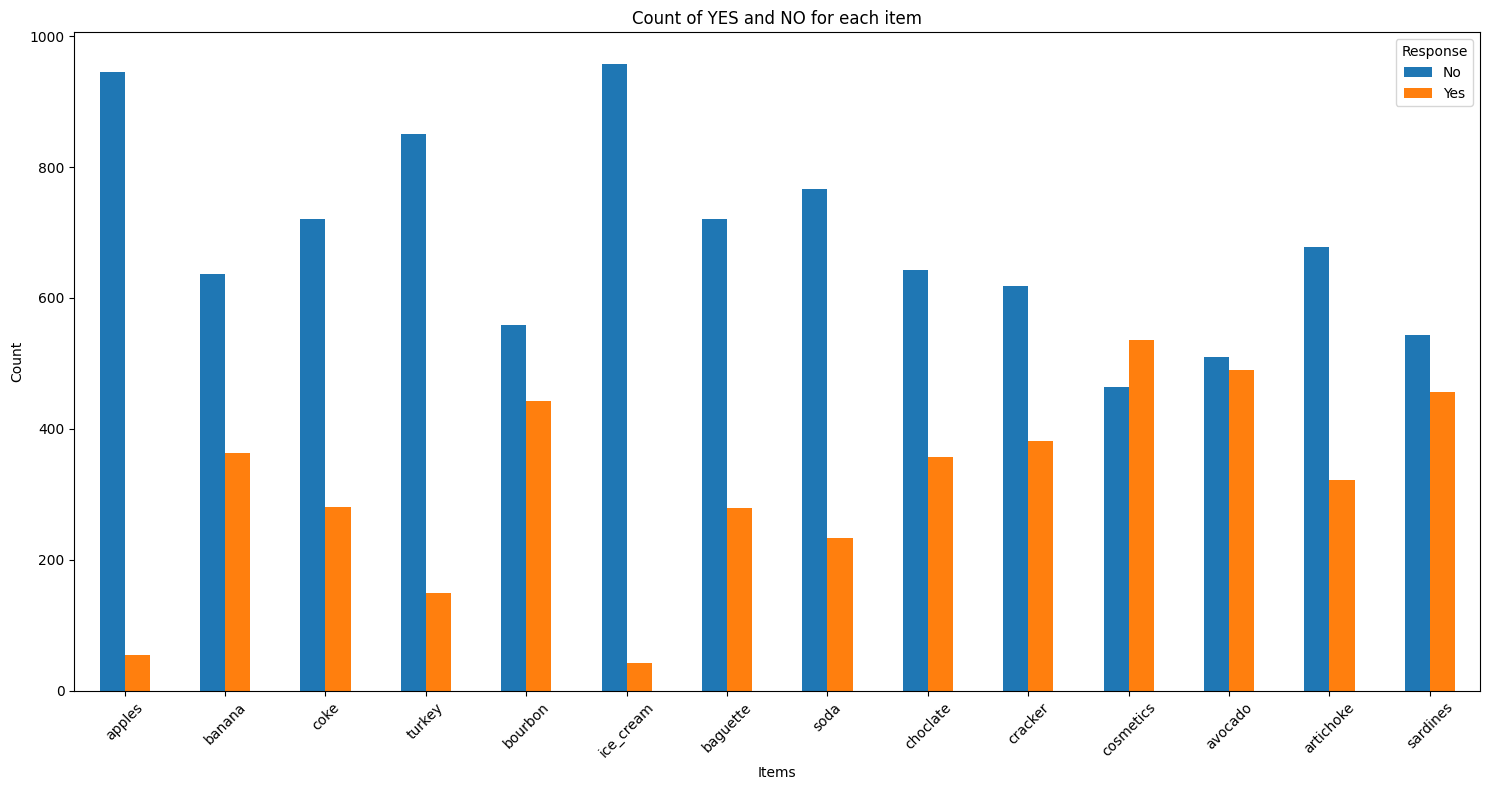

In [192]:
# Count the occurrences of "YES" and "NO" for each column
counts = store_data.apply(lambda x: x.value_counts()).T

# If "YES" or "NO" is missing for any column, fill with 0
counts = counts.fillna(0).astype(int)

# Plot the bar chart
counts.plot(kind='bar', figsize=(15, 8))
plt.title('Count of YES and NO for each item')
plt.xlabel('Items')
plt.ylabel('Count')
plt.legend(title='Response')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [193]:
import random

items = ['apples', 'banana', 'coke', 'turkey', 'bourbon', 'ice_cream',
         'baguette', 'soda', 'choclate', 'cracker', 'cosmetics', 'avocado',
         'artichoke', 'sardines']

def generate_transactions(num_transactions, max_items_per_transaction):
    transactions = []
    for _ in range(num_transactions):
        num_items = random.randint(1, max_items_per_transaction)
        transaction = random.sample(items, num_items)
        transactions.append(transaction)
    return transactions

transactions = generate_transactions(25, 5)
for i, transaction in enumerate(transactions):
    print(f"Transaction {i+1}: {transaction}")

Transaction 1: ['banana', 'turkey']
Transaction 2: ['banana', 'ice_cream', 'soda', 'apples', 'choclate']
Transaction 3: ['cosmetics', 'sardines', 'apples', 'soda']
Transaction 4: ['bourbon']
Transaction 5: ['soda', 'avocado', 'ice_cream']
Transaction 6: ['sardines', 'ice_cream', 'artichoke', 'avocado', 'choclate']
Transaction 7: ['baguette', 'bourbon', 'sardines']
Transaction 8: ['coke', 'choclate', 'cracker', 'baguette']
Transaction 9: ['banana']
Transaction 10: ['choclate', 'ice_cream']
Transaction 11: ['baguette', 'cracker', 'ice_cream']
Transaction 12: ['bourbon', 'avocado']
Transaction 13: ['artichoke', 'banana', 'baguette', 'cracker', 'bourbon']
Transaction 14: ['baguette', 'coke', 'soda']
Transaction 15: ['bourbon']
Transaction 16: ['artichoke']
Transaction 17: ['soda', 'cracker', 'sardines', 'coke', 'artichoke']
Transaction 18: ['cracker']
Transaction 19: ['cracker', 'ice_cream', 'baguette']
Transaction 20: ['choclate', 'sardines', 'apples', 'baguette', 'artichoke']
Transaction

In [194]:
Rules = list(apriori(transactions, min_support=0.1, min_confidence=0.95))
associationRules = ARutils.extract(Rules,"cosmetics",2)
ARutils.inspect(associationRules)

The number of associated rules: 0


In [195]:
rules_df = pd.DataFrame(associationRules, columns=['LHS' , 'RHS', 'Support', 'Confidence', 'Lift'])
rules_df

,LHS,RHS,Support,Confidence,Lift


In [196]:
Rules = list(apriori(transactions, min_support=0.01, min_confidence=0.5))
associationRules = ARutils.extract(Rules)
ARutils.inspect(associationRules)

The number of associated rules: 572
LHS: ['apples'] --> RHS:['choclate'], support: 0.08, confidence: 0.50, lift: 2.50
--------------------------------------------------------------------------------
LHS: ['apples'] --> RHS:['ice_cream'], support: 0.08, confidence: 0.50, lift: 1.79
--------------------------------------------------------------------------------
LHS: ['apples'] --> RHS:['sardines'], support: 0.08, confidence: 0.50, lift: 2.08
--------------------------------------------------------------------------------
LHS: ['apples'] --> RHS:['soda'], support: 0.08, confidence: 0.50, lift: 2.50
--------------------------------------------------------------------------------
LHS: ['artichoke'] --> RHS:['sardines'], support: 0.12, confidence: 0.60, lift: 2.50
--------------------------------------------------------------------------------
LHS: ['sardines'] --> RHS:['artichoke'], support: 0.12, confidence: 0.50, lift: 2.50
----------------------------------------------------------------

In [197]:
rules_df = pd.DataFrame(associationRules, columns=['LHS' , 'RHS', 'Support', 'Confidence', 'Lift'])
rules_df

,LHS,RHS,Support,Confidence,Lift
0,[apples],[choclate],0.08,0.5,2.500000
1,[apples],[ice_cream],0.08,0.5,1.785714
2,[apples],[sardines],0.08,0.5,2.083333
3,[apples],[soda],0.08,0.5,2.500000
4,[artichoke],[sardines],0.12,0.6,2.500000
...,...,...,...,...,...
567,"[cracker, sardines, coke, artichoke]",[soda],0.04,1.0,5.000000
568,"[soda, cracker, coke, artichoke]",[sardines],0.04,1.0,4.166667
569,"[soda, sardines, coke, artichoke]",[cracker],0.04,1.0,3.571429
570,"[soda, cracker, sardines, artichoke]",[coke],0.04,1.0,5.000000


In [198]:
# !pip install plotly
# !pip install --upgrade plotly numpy

In [199]:
import pandas as pd
import plotly.express as px

rules_df = pd.DataFrame(associationRules, columns=['LHS', 'RHS', 'Support', 'Confidence', 'Lift'])
print(rules_df.shape)

fig = px.scatter(rules_df, x="Support", y="Confidence", color="Lift",
                 hover_data=['LHS', 'RHS'],
                 color_continuous_scale=["red", "orange"])
fig.show()

(572, 5)


In [200]:
overlapping_points = rules_df.duplicated(subset=['Support', 'Confidence'], keep=False)
overlapping_df = rules_df[overlapping_points]

print("Number of overlapping points:", len(overlapping_df))
print(overlapping_df)

Number of overlapping points: 569
                                      LHS          RHS  Support  Confidence  \
0                                [apples]   [choclate]     0.08         0.5   
1                                [apples]  [ice_cream]     0.08         0.5   
2                                [apples]   [sardines]     0.08         0.5   
3                                [apples]       [soda]     0.08         0.5   
4                             [artichoke]   [sardines]     0.12         0.6   
..                                    ...          ...      ...         ...   
567  [cracker, sardines, coke, artichoke]       [soda]     0.04         1.0   
568      [soda, cracker, coke, artichoke]   [sardines]     0.04         1.0   
569     [soda, sardines, coke, artichoke]    [cracker]     0.04         1.0   
570  [soda, cracker, sardines, artichoke]       [coke]     0.04         1.0   
571       [soda, cracker, coke, sardines]  [artichoke]     0.04         1.0   

         Lift  
0

In [201]:
Rules = list(apriori(transactions, min_support=0.02, min_confidence=0.2, max_length=3))
associationRules = ARutils.extract(Rules)
rules_df = pd. DataFrame(associationRules, columns=[ 'LHS' , 'RHS' , 'Support' , 'Confidence' , 'Lift' ])#
rules_df[rules_df[ 'RHS' ] . apply(lambda x: 'avocado' in x)]

,LHS,RHS,Support,Confidence,Lift
39,[ice_cream],[avocado],0.08,0.285714,2.380952
169,"[choclate, artichoke]",[avocado],0.04,0.500000,4.166667
173,"[ice_cream, artichoke]",[avocado],0.04,1.000000,8.333333
177,"[sardines, artichoke]",[avocado],0.04,0.333333,2.777778
238,"[ice_cream, choclate]",[avocado],0.04,0.333333,2.777778
242,"[choclate, sardines]",[avocado],0.04,0.500000,4.166667
246,"[ice_cream, sardines]",[avocado],0.04,1.000000,8.333333
250,"[ice_cream, soda]",[avocado],0.04,0.500000,4.166667


In [210]:
Avoocado_rules = rules_df[rules_df[ 'RHS' ] .apply(lambda x: 'avocado' in x) ].sort_values(by=['Lift'], ascending=False)
Avoocado_rules

,LHS,RHS,Support,Confidence,Lift
173,"[ice_cream, artichoke]",[avocado],0.04,1.000000,8.333333
246,"[ice_cream, sardines]",[avocado],0.04,1.000000,8.333333
242,"[choclate, sardines]",[avocado],0.04,0.500000,4.166667
169,"[choclate, artichoke]",[avocado],0.04,0.500000,4.166667
250,"[ice_cream, soda]",[avocado],0.04,0.500000,4.166667
177,"[sardines, artichoke]",[avocado],0.04,0.333333,2.777778
238,"[ice_cream, choclate]",[avocado],0.04,0.333333,2.777778
39,[ice_cream],[avocado],0.08,0.285714,2.380952


In [211]:
fig = px. scatter(Avoocado_rules, x="Support", y="Confidence", color="Lift",hover_data=['LHS' , 'RHS' ], color_continuous_scale=["red", "orange"])
fig. show()

Task

In [243]:
import pandas as pd
from apyori import apriori as ap
import ARutils as ar

In [244]:
Titanic_Data = pd.read_csv('/content/titanic_preprocessed.csv')

In [245]:
Titanic_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2201 entries, 0 to 2200
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Age_Adult     2201 non-null   object
 1   Age_Child     2201 non-null   object
 2   Sex_Female    2201 non-null   object
 3   Sex_Male      2201 non-null   object
 4   Survived      2201 non-null   object
 5   Crew_Member   2201 non-null   object
 6   First_class   2201 non-null   object
 7   Second_class  2201 non-null   object
 8   Third_class   2201 non-null   object
dtypes: object(9)
memory usage: 154.9+ KB


In [246]:
Titanic_Data.shape

(2201, 9)

In [247]:
Titanic_Data.columns

Index(['Age_Adult', 'Age_Child', 'Sex_Female', 'Sex_Male', 'Survived',
       'Crew_Member', 'First_class', 'Second_class', 'Third_class'],
      dtype='object')

In [248]:
Titanic_Data.describe()

,Age_Adult,Age_Child,Sex_Female,Sex_Male,Survived,Crew_Member,First_class,Second_class,Third_class
count,2201,2201,2201,2201,2201,2201,2201,2201,2201
unique,2,2,2,2,2,2,2,2,2
top,Yes,No,No,Yes,No,No,No,No,No
freq,2092,2092,1731,1731,1490,1316,1876,1916,1495


In [249]:
transactions = ar.data_prepare(Titanic_Data)

In [250]:
len(transactions), transactions[:5]

(2201,
 [['Age_Adult', 'Sex_Female', 'Crew_Member'],
  ['Age_Adult', 'Sex_Female', 'Crew_Member'],
  ['Age_Adult', 'Sex_Female', 'Crew_Member'],
  ['Age_Adult', 'Sex_Female', 'Survived', 'Crew_Member'],
  ['Age_Adult', 'Sex_Female', 'Survived', 'Crew_Member']])

In [251]:
rules = list(apriori(
    transactions,
    min_support=0.02,
    min_confidence=0.3,
    min_lift=1.2,
    min_length=2
))

In [252]:
survival_rules = ARutils.extract(rules)

In [253]:
ARutils.inspect(survival_rules)

The number of associated rules: 65
LHS: ['Age_Child'] --> RHS:['Sex_Female'], support: 0.02, confidence: 0.41, lift: 1.93
--------------------------------------------------------------------------------
LHS: ['Age_Child'] --> RHS:['Survived'], support: 0.03, confidence: 0.52, lift: 1.62
--------------------------------------------------------------------------------
LHS: ['Age_Child'] --> RHS:['Third_class'], support: 0.04, confidence: 0.72, lift: 2.26
--------------------------------------------------------------------------------
LHS: ['Crew_Member'] --> RHS:['Sex_Male'], support: 0.39, confidence: 0.97, lift: 1.24
--------------------------------------------------------------------------------
LHS: ['Sex_Male'] --> RHS:['Crew_Member'], support: 0.39, confidence: 0.50, lift: 1.24
--------------------------------------------------------------------------------
LHS: ['First_class'] --> RHS:['Sex_Female'], support: 0.07, confidence: 0.45, lift: 2.09
-------------------------------------

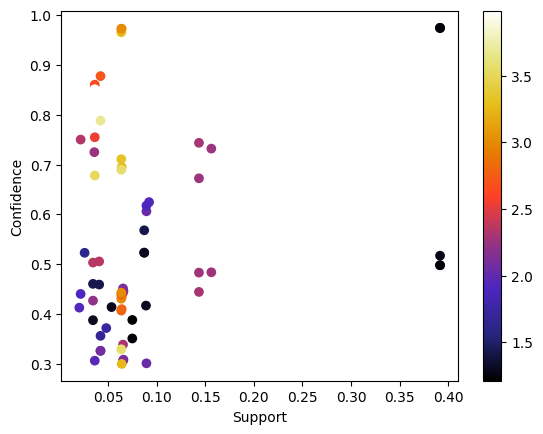

In [258]:
supp = [rule[2] for rule in survival_rules]
conf = [rule[3] for rule in survival_rules]
lif  = [rule[4] for rule in survival_rules]

ar.plot(supp, conf, lif)

In [259]:
filtered_rules = list(filter(lambda rule: 'Survived' in rule[1], survival_rules))

In [260]:
ARutils.inspect(filtered_rules)

The number of associated rules: 24
LHS: ['Age_Child'] --> RHS:['Survived'], support: 0.03, confidence: 0.52, lift: 1.62
--------------------------------------------------------------------------------
LHS: ['First_class'] --> RHS:['Survived'], support: 0.09, confidence: 0.62, lift: 1.93
--------------------------------------------------------------------------------
LHS: ['Second_class'] --> RHS:['Survived'], support: 0.05, confidence: 0.41, lift: 1.28
--------------------------------------------------------------------------------
LHS: ['Sex_Female'] --> RHS:['Survived'], support: 0.16, confidence: 0.73, lift: 2.27
--------------------------------------------------------------------------------
LHS: ['First_class'] --> RHS:['Age_Adult', 'Survived'], support: 0.09, confidence: 0.61, lift: 2.04
--------------------------------------------------------------------------------
LHS: ['First_class', 'Age_Adult'] --> RHS:['Survived'], support: 0.09, confidence: 0.62, lift: 1.91
--------------

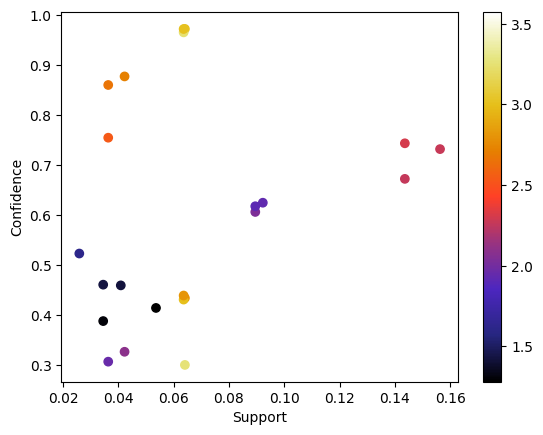

In [261]:
supp = [rule[2] for rule in filtered_rules]
conf = [rule[3] for rule in filtered_rules]
lif  = [rule[4] for rule in filtered_rules]

ar.plot(supp, conf, lif)

Analytics

In [270]:
rules_df = pd.DataFrame(survival_rules, columns=['LHS', 'RHS', 'Support', 'Confidence', 'Lift'])

print("\nCorrelation between metrics:")
print(rules_df[['Support', 'Confidence', 'Lift']].corr())


Correlation between metrics:
            Support  Confidence      Lift
Support     1.00000    0.290760 -0.418710
Confidence  0.29076    1.000000  0.252522
Lift       -0.41871    0.252522  1.000000


In [271]:
rules_df = rules_df.sort_values(by='Lift', ascending=False)
rules_df['Leverage'] = rules_df['Support'] - (rules_df['Support'] * rules_df['Confidence'])
rules_df

,LHS,RHS,Support,Confidence,Lift,Leverage
60,"[Age_Adult, Survived, Second_class]",[Sex_Female],0.036347,0.851064,3.985514,0.005413
42,"[Survived, Second_class]",[Sex_Female],0.042254,0.788136,3.690822,0.008952
51,"[First_class, Survived]","[Sex_Female, Age_Adult]",0.063607,0.689655,3.571602,0.019740
49,"[Sex_Female, Age_Adult]","[First_class, Survived]",0.063607,0.329412,3.571602,0.042654
58,"[Survived, Second_class]","[Sex_Female, Age_Adult]",0.036347,0.677966,3.511067,0.011705
...,...,...,...,...,...,...
4,[Sex_Male],[Crew_Member],0.391640,0.497978,1.238474,0.196612
14,[Sex_Male],"[Crew_Member, Age_Adult]",0.391640,0.497978,1.238474,0.196612
15,"[Crew_Member, Age_Adult]",[Sex_Male],0.391640,0.974011,1.238474,0.010178
30,[Sex_Female],"[Age_Adult, Third_class]",0.074966,0.351064,1.232363,0.048648


In [264]:
strong_rules = rules_df[(rules_df['Lift'] > 2) & (rules_df['Confidence'] > 0.5)]
strong_rules

,LHS,RHS,Support,Confidence,Lift,Leverage
60,"Age_Adult, Survived, Second_class",Sex_Female,0.036347,0.851064,3.985514,0.005413
42,"Survived, Second_class",Sex_Female,0.042254,0.788136,3.690822,0.008952
51,"First_class, Survived","Sex_Female, Age_Adult",0.063607,0.689655,3.571602,0.019740
58,"Survived, Second_class","Sex_Female, Age_Adult",0.036347,0.677966,3.511067,0.011705
54,"First_class, Age_Adult, Survived",Sex_Female,0.063607,0.710660,3.328005,0.018404
38,"First_class, Survived",Sex_Female,0.064062,0.694581,3.252709,0.019566
50,"First_class, Sex_Female","Age_Adult, Survived",0.063607,0.965517,3.249394,0.002193
37,"First_class, Sex_Female",Survived,0.064062,0.972414,3.010243,0.001767
53,"First_class, Age_Adult, Sex_Female",Survived,0.063607,0.972222,3.009650,0.001767
41,"Sex_Female, Second_class",Survived,0.042254,0.877358,2.715986,0.005182
